In [1]:
%matplotlib inline

Model Zoo: https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md

## DeepLab Model

In [ ]:
!git clone https://github.com/tensorflow/models
# From tensorflow/models/research/
!cd models/research/
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

In [2]:
# Following Code Taken From:
# https://colab.research.google.com/github/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb#scrollTo=kAbdmRmvq0Je

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]



#######
# changed for cityscape labels
#LABEL_NAMES = np.asarray([trainId2label[i].name for i in np.arange(19)])
LABEL_NAMES = np.asarray(['road', 'sidewalk', 'building', 'wall', 'fence', 'pole',
       'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky',
       'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle',
       'bicycle'])
#######

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

/sda1/home/chris/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Changed to explicitly pick just a chosen model
_TARBALL_NAME = 'deeplab_model.tar.gz'
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
#deeplab_cityscapes_xception71_trainfine_2018_09_08
#mobilenetv2_coco_cityscapes_trainfine
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
                   download_path)

print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


img_folder = '/home/project/data/Cityscapes/leftImg8bit/val/frankfurt'
img_names = os.listdir(img_folder)
img = skimage.io.imread(img_folder + '/' + random.choice(img_names))
skimage.io.imshow(img)

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'https://i1.wp.com/www.totaltaipei.com/wp-content/uploads/2017/04/fake-accident.jpg?fit=600%2C303'

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

In [4]:
# tensorboard output
graph = MODEL.graph
writer = tf.summary.FileWriter(logdir='models', graph=graph)
writer.flush()

In [5]:
IMAGE_URL = 'https://i1.wp.com/www.totaltaipei.com/wp-content/uploads/2017/04/fake-accident.jpg?fit=600%2C303'

url = IMAGE_URL
f = urllib.request.urlopen(url)
jpeg_str = f.read()
original_im = Image.open(BytesIO(jpeg_str))

image = original_im

width, height = image.size
resize_ratio = 1.0 * MODEL.INPUT_SIZE / max(width, height)
target_size = (int(resize_ratio * width), int(resize_ratio * height))
resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)

logits = MODEL.sess.run(
    'ResizeBilinear_3:0',
    #'logits/semantic/BiasAdd:0',
    feed_dict={MODEL.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})

In [6]:
import matplotlib

In [7]:
cmap = plt.cm.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, 19))

In [8]:
def softmax_to_color(softmax):
    argmax = np.argmax(softmax)
    color = colors[argmax]
    #color_hsv = matplotlib.colors.rgb_to_hsv(color[:-1])
    #color_hsv[1] = color_hsv[1] * softmax[argmax]
    #color_rgb = matplotlib.colors.hsv_to_rgb(color_hsv)
    return color[:-1]

In [9]:
def softmax_to_color_intensity(softmax):
    argmax = np.argmax(softmax)
    color = colors[argmax]
    color_hsv = matplotlib.colors.rgb_to_hsv(color[:-1])
    color_hsv[1] = color_hsv[1] * softmax[argmax]
    color_rgb = matplotlib.colors.hsv_to_rgb(color_hsv)
    return color_rgb

In [28]:
logits = logits[0] # remove batch

In [29]:
img_shape = np.asarray(resized_image).shape[:-1]

In [30]:
logits = logits[:img_shape[0],:img_shape[1]]

In [31]:
softmax = np.apply_along_axis(lambda x: np.exp(x) / np.sum(np.exp(x)), -1, logits)

In [32]:
rgb_softmax = np.zeros(softmax.shape[:-1] + (3,))
for i in range(softmax.shape[0]):
    for j in range(softmax.shape[1]):
        rgb_softmax[i][j] = softmax_to_color(softmax[i][j])

In [33]:
rgb_intensity = np.zeros(softmax.shape[:-1] + (3,))
for i in range(softmax.shape[0]):
    for j in range(softmax.shape[1]):
        rgb_intensity[i][j] = softmax_to_color_intensity(softmax[i][j])

In [16]:
import matplotlib.pyplot as plt

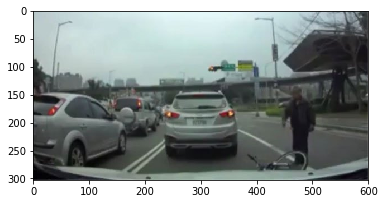

In [17]:
plt.imshow(image)

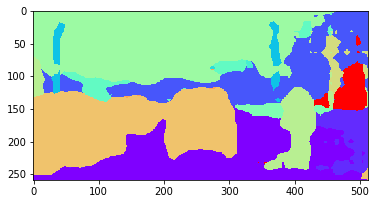

In [34]:
plt.imshow(rgb_softmax)

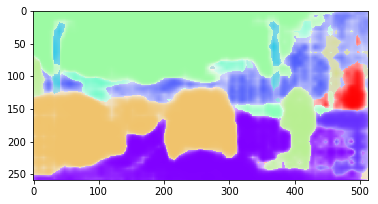

In [35]:
plt.imshow(rgb_intensity)

In [20]:
from tensorflow.contrib import graph_editor as ge

In [26]:
import numpy as np

In [21]:
backup_graph = MODEL.graph

In [ ]:
num_dropout_samples = 30
keep_prob = 0.98
all_logits = []

for i in range(num_dropout_samples):
    graph = backup_graph
    tvars = tf.trainable_variables()
    
    for v in tvars:
        
        size = v.size
        maskm = np.random.choice([0, 1/keep_prob], size=size, p=[1-keep_prob,keep_prob])
        mask = tf.Variable(maskm)
        mop = v.assign(tf.multiply(v, mask))
        
        with tf.session() as sess:
            sess.run(mop)
            
    logits = MODEL.sess.run(
    'ResizeBilinear_3:0',
    #'logits/semantic/BiasAdd:0',
    feed_dict={MODEL.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    
    all_logits.append(logits)
    